In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
import warnings
import imblearn

from collections import Counter

from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers
from tensorflow.keras import losses

from keras.callbacks import ModelCheckpoint

import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences




import pydot

In [2]:
train_data= pd.read_csv('data_train.csv')
train_data.dropna(axis = 0, how ='any',inplace=True) 


train_data['Num_words_text'] = train_data['review'].apply(lambda x:len(str(x).split())) 
mask = train_data['Num_words_text'] >2
train_data = train_data[mask]

print('-------Train data--------')
print(train_data['sentiment'].value_counts())
print(len(train_data))
max_train_sentence_length  = train_data['Num_words_text'].max()

test_data= pd.read_csv('data_test.csv')
test_data.dropna(axis = 0, how ='any',inplace=True) 
test_data['Num_words_text'] = test_data['review'].apply(lambda x:len(str(x).split())) 

max_test_sentence_length  = test_data['Num_words_text'].max()

mask = test_data['Num_words_text'] >2
test_data = test_data[mask]

print('-------Test data--------')
print(test_data['sentiment'].value_counts())
print(len(test_data))
print('-------------------------')

print('Train Max Sentence Length :'+str(max_train_sentence_length))
print('Test Max Sentence Length :'+str(max_test_sentence_length))

#all_sentences = train_data['text'].tolist() + test_data['text'].tolist()

-------Train data--------
positive    7743
negative     755
Name: sentiment, dtype: int64
8498
-------Test data--------
positive    1905
negative     222
Name: sentiment, dtype: int64
2127
-------------------------
Train Max Sentence Length :1206
Test Max Sentence Length :383


In [3]:
num_words = 20000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(train_data['review'].tolist())

# print(str(tokenizer.texts_to_sequences(['nice spot hang friend see also sunset amazing beside many option restaurant choose along'])))

In [4]:
# tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
# lr = LogisticRegression()

# original_pipeline = Pipeline([
#     ('vectorizer', tvec),
#     ('classifier', lr)
# ])

# ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),lr)
# SMOTE_pipeline = make_pipeline(tvec, SMOTE(random_state=777),lr)

In [5]:
X_train, X_valid, y_train, y_valid = train_test_split(train_data['review'].tolist(),\
                                                      train_data['sentiment'].tolist(),\
                                                      test_size=0.2,\
                                                      stratify = train_data['sentiment'].tolist(),\
                                                      random_state=0)

print('Train data len:'+str(len(X_train)))
print('Class distribution'+str(Counter(y_train)))
print('Valid data len:'+str(len(X_valid)))
print('Class distribution'+ str(Counter(y_valid)))

# sm = SMOTE()
# try :
#     x_train_res, y_train_res = sm.fit_resample(X_train, y_train)
# except ValueError:
#     pass


x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )


x_train = pad_sequences(x_train, padding='post', maxlen=1210)
x_valid = pad_sequences(x_valid, padding='post', maxlen=1210)
x_test = pad_sequences(x_test, padding='post', maxlen=390)

print(x_train[0])

le = LabelEncoder()

train_labels = le.fit_transform(y_train)
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
#print(train_labels)
valid_labels = le.transform(y_valid)
valid_labels = np.asarray( tf.keras.utils.to_categorical(valid_labels))

test_labels = le.transform(test_data['sentiment'].tolist())
test_labels = np.asarray(tf.keras.utils.to_categorical(test_labels))
list(le.classes_)


train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

Train data len:6798
Class distributionCounter({'positive': 6194, 'negative': 604})
Valid data len:1700
Class distributionCounter({'positive': 1549, 'negative': 151})


E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[36 68 96 ...  0  0  0]


In [6]:
print(y_train[:10])
train_labels = le.fit_transform(y_train)
print('Text to number')
print(train_labels[:10])
train_labels = np.asarray( tf.keras.utils.to_categorical(train_labels))
print('Number to category')
print(train_labels[:10])

['positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive', 'positive']
Text to number
[1 1 1 1 1 1 1 1 1 1]
Number to category
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [7]:
# count =0
# print('======Train dataset ====')
# for value,label in train_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break
# count =0
# print('======Validation dataset ====')
# for value,label in valid_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break
# print('======Test dataset ====')
# for value,label in test_ds:
#     count += 1
#     print(value,label)
#     if count==2:
#         break

In [8]:
max_features =20000
embedding_dim =64
sequence_length = 1210

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.0005)))                                    

model.add(tf.keras.layers.Conv1D(128,2, padding='valid', activation='relu',\
                                 kernel_regularizer = regularizers.l2(0.0005),\
                                 bias_regularizer = regularizers.l2(0.0005)))                               


model.add(tf.keras.layers.GlobalMaxPooling1D())

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(128, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(128, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(2, activation='sigmoid',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001)))

custom_early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=1, 
    min_delta=0.001, 
    mode='auto'
)
                               

model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), optimizer='adam', metrics=["CategoricalAccuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1210, 64)          1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 1209, 128)         16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [9]:
import graphviz

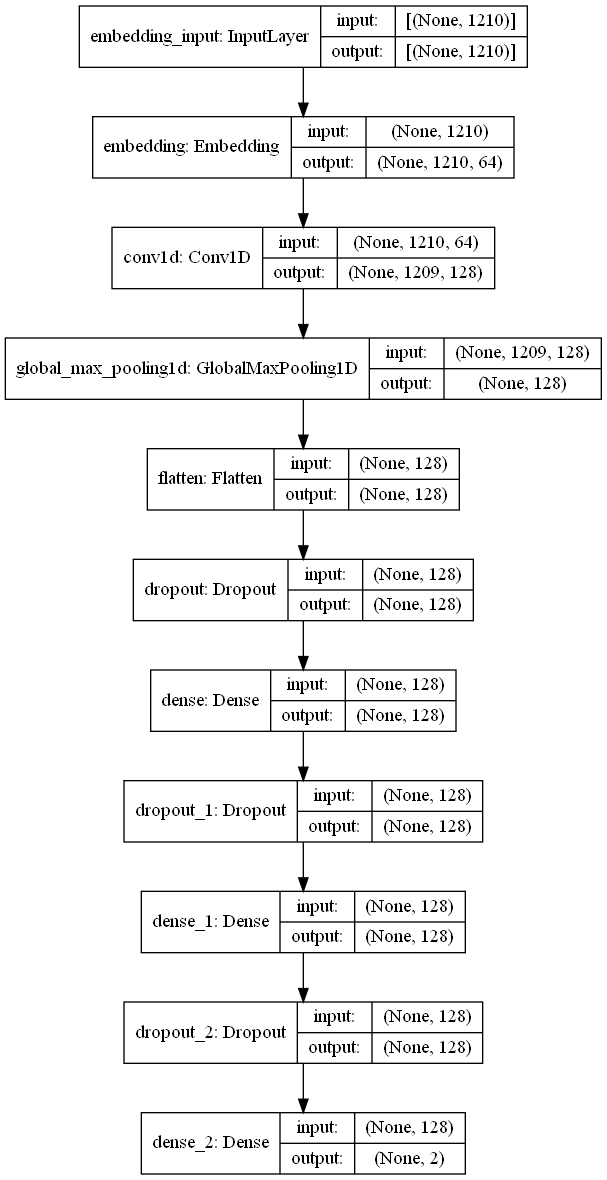

In [10]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [11]:
epochs = 3
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(2000).batch(128),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(128),
                    verbose=1,
                    callbacks=[custom_early_stopping])

Epoch 1/3


E:\Anaconda3\lib\site-packages\tensorflow\python\keras\backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


54/54 [==============================] - 23s 396ms/step - loss: 0.7450 - categorical_accuracy: 0.9067 - val_loss: 0.4717 - val_categorical_accuracy: 0.9112
Epoch 2/3
54/54 [==============================] - 20s 370ms/step - loss: 0.4001 - categorical_accuracy: 0.9112 - val_loss: 0.3587 - val_categorical_accuracy: 0.9112
Epoch 3/3
54/54 [==============================] - 20s 374ms/step - loss: 0.3021 - categorical_accuracy: 0.9138 - val_loss: 0.2853 - val_categorical_accuracy: 0.9265


In [12]:
len(history.history['loss'])

3

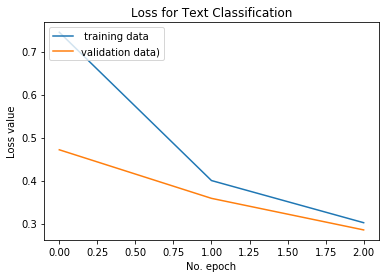

In [13]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data)')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

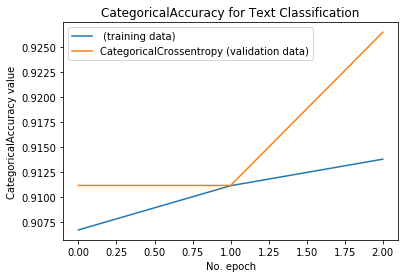

In [14]:
plt.plot(history.history['categorical_accuracy'], label=' (training data)')
plt.plot(history.history['val_categorical_accuracy'], label='CategoricalCrossentropy (validation data)')
plt.title('CategoricalAccuracy for Text Classification')
plt.ylabel('CategoricalAccuracy value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [15]:
model.save('newmodel\\tf_cnnmodel') 
json_string = tokenizer.to_json()

INFO:tensorflow:Assets written to: newmodel\tf_cnnmodel\assets


In [16]:
import json
# with open('tf_cnnmodel', 'w') as outfile:
#     json.dump(json_string, outfile)

In [17]:
new_model = tf.keras.models.load_model('newmodel\\tf_cnnmodel')
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1210, 64)          1280064   
_________________________________________________________________
conv1d (Conv1D)              (None, 1209, 128)         16512     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [18]:
test_data = pd.read_csv('data_test.csv', converters={'reviews.text' : str})
# test_data.drop(["Date", "Content"], axis=1, inplace=True)
# test_data.fillna(0)
test_data.sample(5)

,Date,Content,review,scores,compound,sentiment
453,18-Dec,'Kelingking' in Indonesia language is 'the lit...,kelingking indonesia language little last fing...,"{'neg': 0.171, 'neu': 0.656, 'pos': 0.173, 'co...",0.2746,positive
937,18-May,There may be parts of this beach where you can...,may part swim huge area near ritzcarlton hotel...,"{'neg': 0.0, 'neu': 0.824, 'pos': 0.176, 'comp...",0.5719,positive
1945,17-Aug,Meh! 😐 I am no Globetrotter but I have travell...,meh globetrotter travel world fairly well love...,"{'neg': 0.027, 'neu': 0.573, 'pos': 0.401, 'co...",0.9601,positive
1381,15-Feb,Big beach but some-what dirty ... i would say ...,big somewhat dirty say club restaurant make lo...,"{'neg': 0.093, 'neu': 0.573, 'pos': 0.333, 'co...",0.7713,positive
1629,16-Dec,this beach is a nice place but would be better...,nice place well clean often lot trash wash sho...,"{'neg': 0.0, 'neu': 0.513, 'pos': 0.487, 'comp...",0.7650,positive


In [19]:
try:
    x_test  = np.array( tokenizer.texts_to_sequences(test_data['review'].tolist()) )
    # x_test = tokenizer
    x_test = pad_sequences(x_test, padding='post', maxlen=1210)
except AttributeError:
    pass

E:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [20]:
# Generate predictions (probabilities -- the output of the last layer)
# on test  data using `predict`
print("Generate predictions for all samples")
predictions = new_model.predict(x_test)
print(predictions)
predict_results = predictions.argmax(axis=1)

Generate predictions for all samples
[[0.1536499  0.8410369 ]
 [0.10592109 0.88836485]
 [0.10833153 0.88572   ]
 ...
 [0.1232982  0.87014973]
 [0.50286025 0.49639612]
 [0.18242434 0.81099916]]


In [21]:
test_data['pred_sentiment'] = predict_results
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == 0),'negative',test_data.pred_sentiment)
test_data['pred_sentiment'] = np.where((test_data.pred_sentiment == '1'),'positive',test_data.pred_sentiment)

In [22]:
labels = ['negative', 'positive']
    
print(classification_report(test_data['sentiment'].tolist(),test_data['pred_sentiment'].tolist(),labels=labels))

              precision    recall  f1-score   support

    negative       0.69      0.28      0.40       222
    positive       0.92      0.99      0.95      1905

    accuracy                           0.91      2127
   macro avg       0.81      0.63      0.68      2127
weighted avg       0.90      0.91      0.90      2127



In [23]:
# sentiment = ['negative','positive']
sequence20 = tokenizer.texts_to_sequences(['love this beach'])


test20 = pad_sequences(sequence20, padding="post")
labels[np.around(new_model.predict(test20)).argmax(axis=1)[0]]

'positive'

In [40]:
sequence30 = tokenizer.texts_to_sequences(['bad sunset'])


test30 = pad_sequences(sequence30, padding="post")
labels[np.around(new_model.predict(test30)).argmax(axis=1)[0]]

'negative'

In [25]:
# df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])

confusion_matrix = pd.crosstab(test_data['sentiment'], test_data['pred_sentiment'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted  negative  positive
Actual                       
negative         63       159
positive         28      1877
